# TP Coding autoencoders and variational autoencoders in Pytorch


Author : Alasdair Newson

alasdair.newson@telecom-paris.fr

## Objective:

The goal of this TP is to explore autoencoders and variational autoencoders applied to a simple dataset. In this first part, we will look at an autoencoder applied to MNIST. We recall that an autoencoder is a neural network with the following general architecture:


![AUTOENCODER](https://perso.telecom-paristech.fr/anewson/doc/images/autoencoder_illustration_2.png)

The tensor $z$ in the middle of the network is called a __latent code__, and it belongs to the latent space. It is this latent space which is interesting in autoencoders (for image synthesis, editing, etc).

### Your task:
You need to add the missing parts in the code (parts between # --- START CODE HERE and # --- END CODE HERE or # FILL IN CODE)


First of all, let's load some packages

In [95]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
from torchvision.utils import save_image
from pathlib import Path
import pdb
import numpy as np
import matplotlib.pyplot as plt
def display_images(imgs):
  r = 1
  c = imgs.shape[0]
  fig, axs = plt.subplots(r, c)
  for j in range(c):
    #black and white images
    axs[j].imshow(pytorch_to_numpy(imgs[j, 0,:,:]), cmap='gray')
    axs[j].axis('off')
  plt.show()


def pytorch_to_numpy(x):
  return x.detach().numpy()

ae_dim_1 = 512
ae_dim_2 = 256
z_dim = 10
batch_size = 128

First, we load the mnist dataset.

In [4]:
data_path = Path('./mnist_data')
# MNIST Dataset
mnist_trainset = datasets.MNIST(root=data_path, train=True, transform=transforms.ToTensor(), download=True)
mnist_testset = datasets.MNIST(root=data_path, train=False, transform=transforms.ToTensor(), download=False)

#create data loader with smaller dataset size
max_mnist_size = 1000
mnist_trainset_reduced = torch.utils.data.random_split(mnist_trainset, [max_mnist_size, len(mnist_trainset)-max_mnist_size])[0] 
mnist_train_loader = torch.utils.data.DataLoader(mnist_trainset_reduced, batch_size=batch_size, shuffle=True,drop_last=True)

# download test dataset
max_mnist_size = 512
mnist_testset_reduced = torch.utils.data.random_split(mnist_testset, [max_mnist_size, len(mnist_testset)-max_mnist_size])[0] 
mnist_test_loader = torch.utils.data.DataLoader(mnist_testset_reduced, batch_size=batch_size, shuffle=True,drop_last=True)

mnist_trainset_reduced.dataset.train_data.shape

/home/bneveu/.local/lib/python3.10/site-packages/torchvision/datasets/mnist.py:75: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


torch.Size([60000, 28, 28])

# 1 Vanilla Autoencoder

Now, we define the general parameters of the autoencoder

In [5]:
# autoencoder parameters
n_rows = mnist_trainset_reduced.dataset.train_data.shape[1]
n_cols = mnist_trainset_reduced.dataset.train_data.shape[2]
n_channels = 1
n_pixels = n_rows*n_cols

img_shape = (n_rows, n_cols, n_channels)
n_epochs = 150

Now, define the autoencoder architecture. In the first part, we will use the following MLP architecture :

Encoder :
- Flatten input
- Dense layer, output size h_dim_1 + ReLU
- Dense layer, output size h_dim_2 + ReLU
- Dense layer, output size z_dim (no non-linearity)

Decoder :
- Dense layer, output size h_dim_2 + ReLU
- Dense layer, output size h_dim_1 + ReLU
- Dense layer, output size x_dim + Sigmoid Activation
- Reshape, to size $28\times 28\times 1$

For the Reshape operation, use the ```A.view(dim_1,dim_2,...)``` function, where ```A``` is your tensor.

In [6]:
class AE(torch.nn.Module ):
  def __init__(self, x_dim: int, h_dim1: int, h_dim2: int, z_dim: int,n_rows: int,n_cols: int,n_channels: int):
    """Autoencoder - fully connected for fixed size 28x28 MNIST images - (not convolutional, sorry Mr Lecun)

    Args:
        x_dim (int): 28²
        h_dim1 (int): hidden dimension layer 1
        h_dim2 (int): hidden dimension layer 2
        z_dim (int): latent dimension
        n_rows (int): height of the image
        n_cols (int): width of the image
        n_channels (int): number of channels
    """
    super(AE, self).__init__()
    assert n_cols*n_rows == x_dim, "wrong dimension"
    self.n_rows = n_rows
    self.n_cols = n_cols
    self.n_channels = n_channels
    self.n_pixels = (self.n_rows)*(self.n_cols)
    self.z_dim = z_dim

    # encoder part
    self.fc1 =  torch.nn.Linear(x_dim,  h_dim1)
    self.fc2 = torch.nn.Linear(h_dim1,  h_dim2)
    self.fc3 = torch.nn.Linear(h_dim2,  z_dim)
    self.non_lin = torch.nn.ReLU()
    self.encoder = torch.nn.Sequential(
      self.fc1, self.non_lin, self.fc2, self.non_lin, self.fc3
    )
    # decoder part
    self.fc4 = torch.nn.Linear(z_dim,  h_dim2)
    self.fc5 = torch.nn.Linear(h_dim2,  h_dim1)
    self.fc6 = torch.nn.Linear(h_dim1,  x_dim)
    self.sigmoid = torch.nn.Sigmoid()
    self.decoder = torch.nn.Sequential(
      self.fc4, self.non_lin, self.fc5, self.non_lin, self.fc6, self.sigmoid
    )

  def forward(self, x):
    # N, (C=1), H, W -> N, C*H*W
    z = self.encoder(x.view(-1, self.n_pixels))
    y = self.decoder(z)
    y = y.view(x.shape)
    return y
  def loss_function(self,x, y):
    mse_loss = torch.nn.functional.mse_loss(x, y, reduction="mean")
    return torch.mean(mse_loss)

In [7]:
# create model

ae_model = AE(x_dim=n_pixels, h_dim1= ae_dim_1, h_dim2=ae_dim_2, z_dim=z_dim,n_rows=n_rows,n_cols=n_cols,n_channels=n_channels)
ae_optimizer = optim.Adam(ae_model.parameters())

In [8]:
# sanity check
x_in = torch.rand(10, n_rows, n_cols, n_channels)
x_out = ae_model(x_in)
assert x_out.shape == x_in.shape, "wrong shape"

Now, define a generic function to train the model for one epoch

In [10]:
def train_ae(ae_model,data_train_loader,epoch):
	train_loss = 0
	for batch_idx, (data, _) in enumerate(data_train_loader):
		ae_optimizer.zero_grad()
		
		y = ae_model(data)
		loss_ae = ae_model.loss_function(y, data)

		loss_ae.backward()
		train_loss += loss_ae.item()
		ae_optimizer.step()
		
		if batch_idx % 100 == 0:
			print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
				epoch, batch_idx * len(data), len(data_train_loader.dataset),
				100. * batch_idx / len(data_train_loader), loss_ae.item() / len(data)))
	print('====> Epoch: {} Average loss: {:.4f}'.format(epoch, train_loss / len(data_train_loader.dataset)))


We define a function to carry out testing on the autoencoder model

In [11]:
for epoch in range(0, n_epochs):
  train_ae(ae_model,mnist_train_loader,epoch)

Train Epoch: 0 [0/1000 (0%)]	Loss: 0.001807
====> Epoch: 0 Average loss: 0.0014
Train Epoch: 1 [0/1000 (0%)]	Loss: 0.000760
====> Epoch: 1 Average loss: 0.0006
Train Epoch: 2 [0/1000 (0%)]	Loss: 0.000640
====> Epoch: 2 Average loss: 0.0006
Train Epoch: 3 [0/1000 (0%)]	Loss: 0.000589
====> Epoch: 3 Average loss: 0.0005
Train Epoch: 4 [0/1000 (0%)]	Loss: 0.000582
====> Epoch: 4 Average loss: 0.0005
Train Epoch: 5 [0/1000 (0%)]	Loss: 0.000572
====> Epoch: 5 Average loss: 0.0005
Train Epoch: 6 [0/1000 (0%)]	Loss: 0.000586
====> Epoch: 6 Average loss: 0.0005
Train Epoch: 7 [0/1000 (0%)]	Loss: 0.000532
====> Epoch: 7 Average loss: 0.0005
Train Epoch: 8 [0/1000 (0%)]	Loss: 0.000534
====> Epoch: 8 Average loss: 0.0005
Train Epoch: 9 [0/1000 (0%)]	Loss: 0.000509
====> Epoch: 9 Average loss: 0.0005
Train Epoch: 10 [0/1000 (0%)]	Loss: 0.000505
====> Epoch: 10 Average loss: 0.0004
Train Epoch: 11 [0/1000 (0%)]	Loss: 0.000472
====> Epoch: 11 Average loss: 0.0004
Train Epoch: 12 [0/1000 (0%)]	Loss: 

In [14]:
def display_ae_images(ae_model, test_imgs):
  n_images = 5
  idx = np.random.randint(0, test_imgs.shape[0], n_images)
  test_imgs = test_imgs[idx,:,:,:]
  print(test_imgs.shape)

  #get output images
  output_imgs = pytorch_to_numpy(ae_model.forward( test_imgs ))
  print(output_imgs.shape)
  
  r = 2
  c = n_images
  fig, axs = plt.subplots(r, c)
  for j in range(c):
    #black and white images
    axs[0,j].imshow(test_imgs[j, 0,:,:], cmap='gray')
    axs[0,j].axis('off')
    axs[1,j].imshow(output_imgs[j, 0,:,:], cmap='gray')
    axs[1,j].axis('off')
  plt.suptitle(f"(top row) Original\n (bottom row) AE compressed/decompressed images\ncompression ratio {z_dim/n_pixels:.3%}")
  plt.show()

torch.Size([5, 1, 28, 28])
(5, 1, 28, 28)


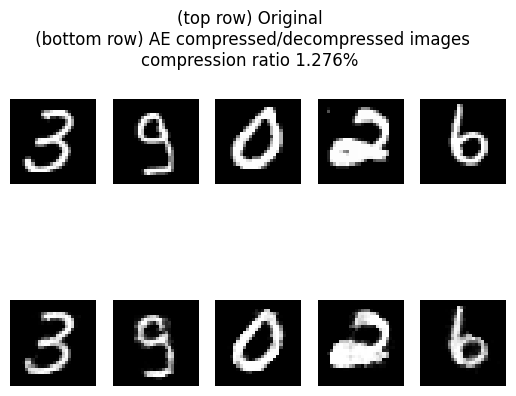

In [15]:
test_imgs = next(iter(mnist_train_loader))[0]
display_ae_images(ae_model, test_imgs)

__Question__ Are you satisfied with the results, do they look good ?

__Your answer:__
Overall, digits look similar to the input despite the auto-encoder high compression rate (factor 1.276%).
The images look slightly blurier than the inputs.
Some details are removed if you look carefully, for instance the loop in the 4th image (the second six) has been closed.

![](figures/ae_samples.png)

## 2/ Two simple generative models

In this section, we consider two naïve approaches to creating generative models. The general idea is the following:

- train an autoencoder
- estimate different statistics (average, variance) of the data in the latent space
- using these statistics, define a model based on a Gaussian distribution
- generate data with this distribution

We will consider these two situations :

- a multivariate Gaussian distribution with __diagonal covariance matrix__ (each latent component is an independent random variable). This requires the average and variance in each latent component
- a multivariate Gaussian distribution with __non-diagonal covariance matrix__. This requires the average and covariance matrix of the latent components

Obviously, since this is done _a posteriori_ after training the autoencoder, there is nothing which guarantees that the latent codes do indeed follow a Gaussian distribution. Our goal will be to verify that Variational Autoencoders indeed produce better results than such naïve approaches.

## 2.0 Defining and generating random Gaussian latent codes

Let $z$ be a latent code and $d$ the dimension of the latent space (called ``z_dim`` in the code). We suppose that the $z$'s follow a multivariate Gaussian distribution, written as:

\begin{equation}
z \sim \mathcal{N}\left(
\mu,
\bf{C}
\right),
\end{equation}
where $\mu$ and $\bf{C}$ are the average vector and covariance matrix of the Gaussian distribution. To define such a generative model, we must therefore determine $\mu$ and $\bf{C}$. Once this is done, we can generate a random Gaussian latent code in the following manner:

\begin{equation}
z = \mu + {\bf{L}} \varepsilon,
\end{equation}
where $\varepsilon$ is a random vector drawn from a multivariate normal distribution ($\mu=0$ and ${\bf{C}} = \text{Id}$), and $\bf{L}$ is the Cholesky decomposition of the positive semi-definite covariance matrix. In other words:

\begin{equation}
{\bf{C}} = {\bf{L}}{\bf{L}^T}.
\end{equation}

This gives a simple method of producing a multivariate Gaussian random variable.

## 2.1/ A Gaussian model with diagonal covariance

The first naïve model is  defined in this first case as:

- $\bf{\mu}=\left[\mu_0, \mu_1, \cdots, \mu_{d-1}\right]^T$
- $
  \bf{C} = \begin{pmatrix}
\sigma_0^2 & 0 & \cdots & 0 \\
0 & \sigma_1^2 & \cdots & 0 \\
\vdots & \ddots & \ddots & \vdots \\
0 & 0 & \cdots & \sigma_{d-1}^2
\end{pmatrix}$

In this situation, therefore, the matrix $\bf{L}$ can be calculated quite simply, as:
- $
  \bf{L} = \begin{pmatrix}
\sigma_0 & 0 & \cdots & 0 \\
0 & \sigma_1 & \cdots & 0 \\
\vdots & \ddots & \ddots & \vdots \\
0 & 0 & \cdots & \sigma_{d-1}
\end{pmatrix}$

In the next cell, calculate the empirical average and variances over a certain number of batches:

In [195]:
n_batches = np.floor(len(mnist_train_loader.dataset.indices)/batch_size).astype(int)
with torch.no_grad():
    ae_model.eval()
    z_average = torch.zeros(n_batches, ae_model.z_dim)
    z_sigma = torch.zeros(n_batches, ae_model.z_dim)

    for batch_idx, (data, _) in enumerate(mnist_train_loader):
        z = ae_model.encoder(data.view(data.shape[0], -1))
        z_average[batch_idx, :] = torch.mean(z, 0)
        z_sigma[batch_idx, :] = torch.std(z, 0)

    z_average = torch.mean(z_average, 0)
    z_sigma = torch.mean(z_sigma, 0)

print("Average of latent codes:", z_average)
print("Standard deviation of latent codes:", z_sigma)

Average of latent codes: tensor([-1.8950, -2.8989,  4.1039, -2.1516,  3.1355,  3.9627, -3.7008, -1.8233,
         4.5559,  1.1885])
Standard deviation of latent codes: tensor([3.4938, 5.1418, 3.2634, 4.0588, 3.8447, 4.2523, 3.8816, 3.4964, 3.7547,
        3.4330])


Now, in the next cell generate data with this simple generative model using the approach described above. Display these images with the ``display_images`` function. 

__NB__ You do not actually have to define the matrix $\bf{L}$ in this case, an element-wise multiplication of two (properly chosen) vectors will suffice. To generate multivariate normal random variables you can use the following Pytorch function:

- ```torch.randn```


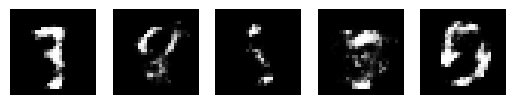

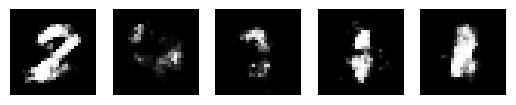

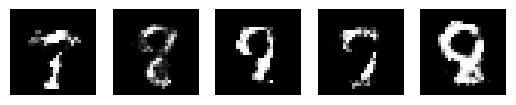

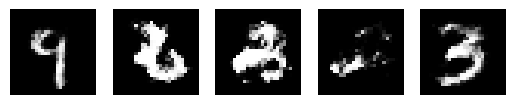

In [103]:
def generate_images_diagonal_gaussian(
    ae_model: AE,
    z_average: torch.Tensor,
    z_sigma: torch.Tensor ,n_images: int = 5) -> torch.Tensor:
  epsilon =  torch.randn(n_images, ae_model.z_dim)
  # z_generated = torch.matmul(epsilon,torch.diag(z_sigma)) + z_average
  z_generated = z_average + z_sigma*epsilon
  imgs_generated = ae_model.decoder(z_generated)
  imgs_generated = imgs_generated.view(n_images,1,n_rows,n_cols)
  return(imgs_generated)

imgs_generated = generate_images_diagonal_gaussian(ae_model,z_average,z_sigma,n_images=20)
display_images(imgs_generated[:5])
display_images(imgs_generated[5:10])
display_images(imgs_generated[10:15])
display_images(imgs_generated[15:20])

As you should be able to see, these results are not that good. Let's try a slightly more sophisticated model.

![](figures/ae_latent_diagonal_generation.png)

## 2.1 Non-diagonal Gaussian model

The second model uses a non-diagonal covariance matrix $\bf{C}$ in the multivariate Gaussian distribution. In the next cell, calculate the average and covariance matrix over several batches of latent codes.

__NB__ You can use the ```torch.cov``` function. Make sure to put the data in the right format for this (see documentation : https://pytorch.org/docs/stable/generated/torch.cov.html).

In [55]:
mnist_train_loader.batch_size

128

In [194]:
n_batches = np.floor(len(mnist_train_loader.dataset.indices)/batch_size).astype(int)
with torch.no_grad():
    ae_model.eval()
    z_average = torch.zeros(n_batches, ae_model.z_dim)
    z_covariance_approx = torch.zeros(n_batches, ae_model.z_dim, ae_model.z_dim)
    latents_stack = torch.zeros(n_batches, mnist_train_loader.batch_size, ae_model.z_dim)
    for batch_idx, (data, _) in enumerate(mnist_train_loader):
        z = ae_model.encoder(data.view(data.shape[0],-1))
        z_average[batch_idx, :] = torch.mean(z, 0)
        # z_covariance_approx[batch_idx, :, :] = torch.cov(z.T)
        # similar to (torch.matmul((z-z_average).T,(z-z_average))/z.shape[0])
        latents_stack[batch_idx, :, :] = z
    z_average = torch.mean(z_average, 0)
    # z_covariance_approx = torch.mean(z_covariance, 0) # THIS IS AN APPROXIMATION OF THE COVARIANCE MATRIX x²+y² != x²
    z_covariance =torch.cov(latents_stack.view(-1, ae_model.z_dim).T)
assert torch.allclose(z_covariance, z_covariance.T), "Covariance matrix is not symmetric"
print("Average of latent codes:", z_average)
print("Covariance matrix of latent codes:", z_covariance)

Average of latent codes: tensor([-1.8891, -2.9401,  4.1222, -2.1018,  3.1426,  3.9225, -3.6981, -1.8968,
         4.5966,  1.1510])
Covariance matrix of latent codes: tensor([[ 3.1076e+01,  2.2061e+00, -1.8643e+01, -5.0480e-01,  5.8635e+00,
         -5.8430e+00,  1.1206e+01, -5.8394e+00, -1.5245e+01,  5.4148e+00],
        [ 2.2061e+00,  6.5698e+01, -1.7879e+01, -6.9385e+00, -1.6635e+01,
         -5.7837e+00,  2.9270e+01,  6.2434e+00, -2.7235e+01, -1.0860e+01],
        [-1.8643e+01, -1.7879e+01,  4.2725e+01, -6.8043e+00,  1.0059e+01,
          1.8224e+01, -2.0280e+01, -3.4973e-01,  2.2221e+01, -5.8344e+00],
        [-5.0480e-01, -6.9385e+00, -6.8043e+00,  4.1138e+01, -1.0630e+01,
         -5.0947e+00, -3.4200e+00,  3.0573e+00, -1.3085e+01, -1.2093e+01],
        [ 5.8635e+00, -1.6635e+01,  1.0059e+01, -1.0630e+01,  4.1812e+01,
          1.4944e+01, -2.4926e+01, -1.4168e+01,  1.8873e+01,  1.7817e+00],
        [-5.8430e+00, -5.7837e+00,  1.8224e+01, -5.0947e+00,  1.4944e+01,
          5.56

Now, generate some samples with this distribution. In this case, you will actually have to calculate the Cholesky decomposition and find $\bf{L}$. For this, you can use 

- ```torch.linalg.cholesky```

In this model, you will need to carry out matrix multiplication over a batch of latent codes, which is a bit more complicated than the previous naïve model (which used element-wise vector multiplication). So you have two options:

- copy the matrix $\bf{L}$ several times and carry out batch matrix multiplication
- simply loop and carry out normal matrix multiplication to produce each image (this has the disadvantage of not taking advantage of any parallelisation, but it should not matter too much).

In the first case, you can use the following functions:

- ```torch.bmm```
- ```torch.tile```

Fill in the function to generate images using this model now:

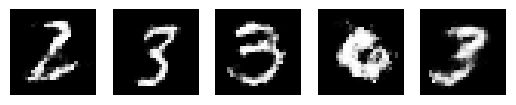

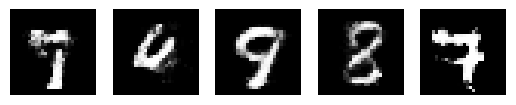

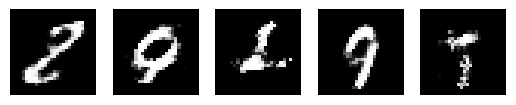

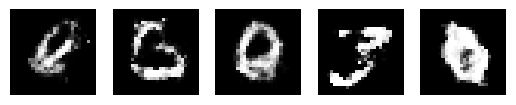

In [100]:
def generate_images_non_diagonal_gaussian(ae_model: AE, z_average: torch.Tensor, z_covariance: torch.Tensor, n_images: int = 5) -> torch.Tensor:
  # Calculate Cholesky decomposition of covariance matrix: C = L L^T
  # Make sure that the first dimension is the batch dimension (with batch size n_images)
  # You can use the torch.unsqueeze function for this
  L = torch.linalg.cholesky(z_covariance)
  epsilon = torch.randn(n_images, ae_model.z_dim)
  z_generated = z_average + torch.matmul(epsilon, L.T)
  imgs_generated = ae_model.decoder(z_generated)
  imgs_generated = imgs_generated.view(n_images, 1, n_rows, n_cols)
  return imgs_generated

imgs_generated = generate_images_non_diagonal_gaussian(ae_model, z_average, z_covariance, n_images=20)
display_images(imgs_generated[:5])
display_images(imgs_generated[5:10])
display_images(imgs_generated[10:15])
display_images(imgs_generated[15:20])

You should see some improvement, but we can do better than this. Thus, we turn to the variational autoencoder.

# 3/ Variational autoencoder

Now, we are going to create an variational autoencoder to carry out __image generation__. Let's first recall the idea of a variational autoencoder

## Main idea

The main idea is to create an autoencoder whose latent codes follow a certain distribution (a Gaussian distribution in practice). This is done with two tools : 

- A specific architecture, where the encoder produces the average and variance of the latent codes
- A specially designed loss function

Once the VAE is trained, it is possible to sample in the latent space by producing random normal variables and simply decoding.

## Architecture

The architecture of the VAE model is as follows:

The encoder consists of:

Encoder :
- Flatten input
- Dense layer $+$ ReLU
- Dense layer $+$ ReLU
- Dense layer (no non-linarity) to produce the average, Dense layer (no non-linarity) to produce the variance (these last two layers are in parallel)

Decoder :
- Dense layer $+$ ReLU
- Dense layer $+$ ReLU
- Dense layer $+$ Sigmoid Activation
- Reshape, to size $28\times 28\times 1$


## Variational Autoencoder loss

Recall that for the VAE, the loss function is in fact a function to __maximise__. In fact, for implementation, you will see that it is easier to __minimise__ $-\mathcal{L}$.

In the case of an image which is represented by a set of __Bernoulli__ variables (which is relevant for mnist), the original loss function (to maximise) is written :


\begin{align}
\mathcal{L} &= \log\left(p_\theta(x|z)\right) - KL\left( q_\phi(z|x) \; || \; p_\theta(z)\right) \\
    &= \left(\sum_{i} x_i \log y_i + (1-x_i) \log (1-y_i)\right) - \left(\frac{1}{2} \sum_j \left( \sigma_j^2 + \mu_j^2 - \log \sigma_j^2 -1 \right)\right)
\end{align}


where $i$ is summed over the image pixels, and $j$ is summed over the elements of the latent space. $\sigma_j^2$ is the $j$th element of the latent space variance, and $\mu_j$ is the $j$th element of the latent space mean.

The left part of the loss (reconstruction error) can be implemented simply as the binary cross-entropy between the input x and the output y. Since we are __maximising__ $-$[binary cross-entropy] (look at the formula), this is equivalent to minimising the binary cross-entropy.

For the right part of the equation (KL divergence), you need to implement it manually. 

The final loss is the average, over the batch size, of the sum of the reconstruction error (left part) and the KL divergence (right part). Be careful, in the formula, the sums over $i$ and $j$ are over the number of pixels and the number of latent elements, respectively. To achieve a sum rather than an average, you can use ```torch.nn.BCELoss(reduction='sum')()```, and the ```torch.sum()``` functions.

As in the case of the normal autoencoder, you will need to flatten and then reshape the tensors at the beginning/end of the network.

In [104]:
from typing import Tuple
class VAE(torch.nn.Module ):
  def loss_function(self,x: torch.Tensor, y: torch.Tensor, mu: torch.Tensor, log_var: torch.Tensor) -> torch.Tensor:
    """Cross entropy loss function + KL divergence on the latent space µ and sigma
    Warning: 
    - the reconstruction error should not be divided by the number of pixels in the image
    - 1/2 is the KL weight

    Args:
        x (torch.Tensor): input N, C, H, W
        y (torch.Tensor): output (to compute the reconstuction error)
        mu (torch.Tensor): gaussian average µ
        log_var (torch.Tensor): log of the variance (so we avoid negative variances)

    Returns:
        torch.Tensor: reconstruction error - 0.5 KL divergence between the prior and the standard normal distribution
    """
    
    # loss should be around 105-115
    reconstruction_loss = torch.nn.BCELoss(reduction="sum")
    reconstruction_error = - reconstruction_loss(y, x)
    variance = self.log_var_to_var(log_var) #exp basically
    kld = mu**2 + variance - 1. - log_var
    kld = kld.sum()
    loss = (reconstruction_error - 0.5*kld)/x.shape[0] #average over the batch dimension!

    return loss

  def __init__(self, x_dim, h_dim1, h_dim2, z_dim,n_rows,n_cols,n_channels):
    super(VAE, self).__init__()

    self.n_rows = n_rows
    self.n_cols = n_cols
    self.n_channels = n_channels
    self.n_pixels = (self.n_rows)*(self.n_cols)
    self.z_dim = z_dim

    # encoder part
    self.non_lin = torch.nn.ReLU()
    self.fc1 =  torch.nn.Linear(x_dim,  h_dim1)
    self.fc2 = torch.nn.Linear(h_dim1,  h_dim2)
    self.fc31 = torch.nn.Linear(h_dim2,  z_dim)
    self.fc32 = torch.nn.Linear(h_dim2,  z_dim)
    
    self.encoder_start = torch.nn.Sequential(
      self.fc1, self.non_lin, self.fc2, self.non_lin
    )
    # decoder part
    self.fc4 = torch.nn.Linear(z_dim,  h_dim2)
    self.fc5 = torch.nn.Linear(h_dim2,  h_dim1)
    self.fc6 = torch.nn.Linear(h_dim1,  x_dim)
    self.sigmoid = torch.nn.Sigmoid()
    self.decoder = torch.nn.Sequential(
      self.fc4, self.non_lin, self.fc5, self.non_lin, self.fc6, self.sigmoid
    )

  def encoder(self, x: torch.Tensor) -> tuple[torch.Tensor, torch.Tensor]:
    h = self.encoder_start(x)
    mu = self.fc31(h)
    log_var = self.fc32(h)
    return mu, log_var # mu, log_var

  def log_var_to_var(self, log_var: torch.Tensor) -> torch.Tensor:
    return torch.exp(log_var)
  def sampling(self, mu, log_var):
    # this function samples a Gaussian distribution, with average (mu) and standard deviation specified (using log_var)
    std = self.log_var_to_var(log_var)
    eps = torch.randn(mu.shape, requires_grad=False)
    return eps.mul(std).add_(mu) # return z sample

  def forward(self, x: torch.Tensor, forced_log_var: float=None) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
    z_mu, z_log_var = self.encoder(x.view(-1, self.n_pixels))
    if forced_log_var is not None:
      z_log_var = torch.ones_like(z_log_var) * forced_log_var
    z = self.sampling(z_mu, z_log_var)
    y = self.decoder(z)
    y = y.view(x.shape)
    return y, z_mu, z_log_var


vae_dim_1 = ae_dim_1
vae_dim_2 = ae_dim_2
vae_model = VAE(x_dim=n_pixels, h_dim1= vae_dim_1, h_dim2=vae_dim_2, z_dim=z_dim,n_rows=n_rows,n_cols=n_cols,n_channels=n_channels)
for x_in in [torch.rand(8, 1, 28, 28), torch.rand(8, 28, 28)]:
  y_out, mu_out, log_var_out  = vae_model(x_in)
  assert y_out.shape == x_in.shape
  # print(mu_out.shape, log_var_out.shape)
  my_loss = vae_model.loss_function(x_in, y_out, mu_out, log_var_out)
  print(my_loss.shape)

torch.Size([])
torch.Size([])


Now, create the model (similarly as above)

In [105]:
# create model
vae_dim_1 = ae_dim_1
vae_dim_2 = ae_dim_2
vae_model = VAE(x_dim=n_pixels, h_dim1= vae_dim_1, h_dim2=vae_dim_2, z_dim=z_dim,n_rows=n_rows,n_cols=n_cols,n_channels=n_channels)
vae_optimizer = optim.Adam(vae_model.parameters())

Finally, train the model. First modify the training function to the case of the vae.

In [106]:
def train_vae(vae_model,data_train_loader,epoch):
  train_loss = 0
  for batch_idx, (data, _) in enumerate(data_train_loader):
    vae_optimizer.zero_grad()

    y, z_mu, z_log_var = vae_model(data) # FILL IN CODE HERE
    loss_vae =  vae_model.loss_function(data, y, z_mu, z_log_var) # FILL IN CODE HERE
    loss_vae_neg  = - loss_vae
    (loss_vae_neg).backward()
    # loss_vae.backward()
    train_loss += loss_vae.item()
    vae_optimizer.step() 
		
    if batch_idx % 100 == 0:
      print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
      epoch, batch_idx * len(data), len(data_train_loader.dataset),
      100. * batch_idx / len(data_train_loader), loss_vae.item() / len(data)))
  print('====> Epoch: {} Average loss: {:.4f}'.format(epoch, train_loss / len(data_train_loader.dataset)))


In [107]:
# now train the model
for epoch in range(0, n_epochs):
  train_vae(vae_model,mnist_train_loader,epoch)

Train Epoch: 0 [0/1000 (0%)]	Loss: -4.250510
====> Epoch: 0 Average loss: -3.2086
Train Epoch: 1 [0/1000 (0%)]	Loss: -2.180223
====> Epoch: 1 Average loss: -1.8457
Train Epoch: 2 [0/1000 (0%)]	Loss: -1.821287
====> Epoch: 2 Average loss: -1.5719
Train Epoch: 3 [0/1000 (0%)]	Loss: -1.714563
====> Epoch: 3 Average loss: -1.4942
Train Epoch: 4 [0/1000 (0%)]	Loss: -1.630244
====> Epoch: 4 Average loss: -1.4757
Train Epoch: 5 [0/1000 (0%)]	Loss: -1.634551
====> Epoch: 5 Average loss: -1.4467
Train Epoch: 6 [0/1000 (0%)]	Loss: -1.572440
====> Epoch: 6 Average loss: -1.4389
Train Epoch: 7 [0/1000 (0%)]	Loss: -1.580708
====> Epoch: 7 Average loss: -1.4197
Train Epoch: 8 [0/1000 (0%)]	Loss: -1.574780
====> Epoch: 8 Average loss: -1.4113
Train Epoch: 9 [0/1000 (0%)]	Loss: -1.572292
====> Epoch: 9 Average loss: -1.4131
Train Epoch: 10 [0/1000 (0%)]	Loss: -1.588510
====> Epoch: 10 Average loss: -1.4018
Train Epoch: 11 [0/1000 (0%)]	Loss: -1.568540
====> Epoch: 11 Average loss: -1.3972
Train Epoch:

Now, generate some images with the VAE model

/tmp/ipykernel_234462/3141267753.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  selected_imgs_tensor = torch.tensor(selected_imgs, dtype=torch.float32)


(5, 1, 28, 28)


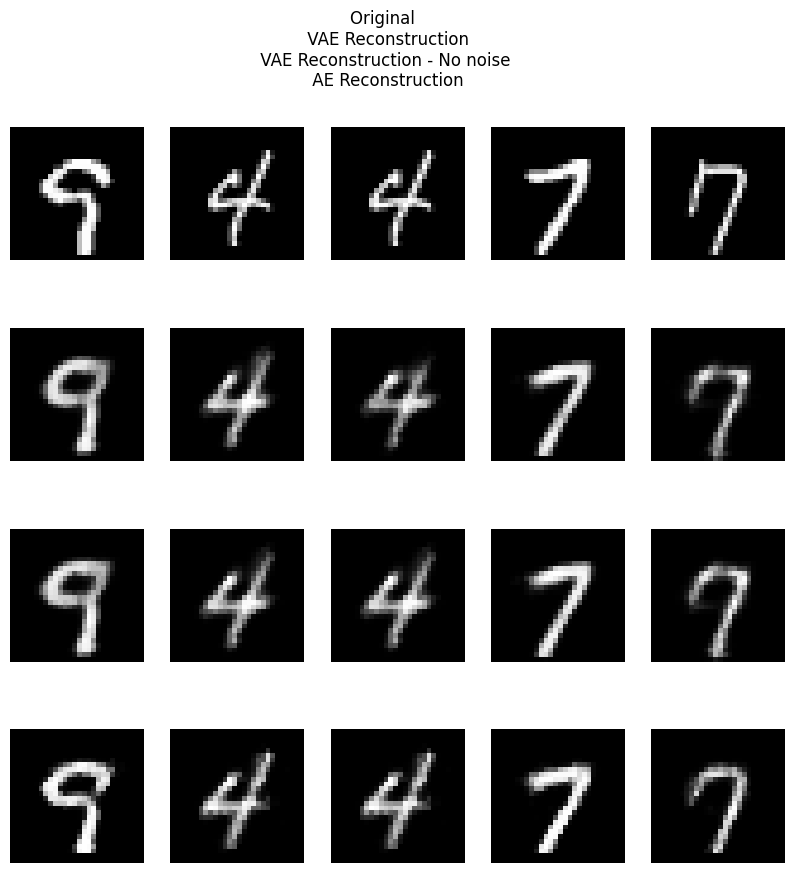

In [109]:
import numpy as np
import matplotlib.pyplot as plt
import torch

def display_vae_images(ae_model, vae_model,test_imgs):
    n_images = 5
    idx = np.random.randint(0, test_imgs.shape[0], n_images)
    selected_imgs = test_imgs[idx,:,:,:]

    selected_imgs_tensor = torch.tensor(selected_imgs, dtype=torch.float32)
    output_imgs_vae, _, _ = vae_model(selected_imgs_tensor, forced_log_var=None)
    output_imgs_vae = output_imgs_vae.detach().cpu().numpy()

    output_imgs_vae_not_noisy, _, _ = vae_model(selected_imgs_tensor, forced_log_var=-torch.inf)
    output_imgs_vae_not_noisy = output_imgs_vae_not_noisy.detach().cpu().numpy()

    output_imgs_ae = ae_model(selected_imgs_tensor)
    output_imgs_ae = output_imgs_ae.detach().cpu().numpy()
   
    print(output_imgs_vae.shape)

    r = 4  # 3 rows: one for original and one for reconstructed images with VAE and AE
    c = n_images  # Number of columns equals the number of images to display
    fig, axs = plt.subplots(r, c, figsize=(10, 10))
    for j in range(c):
        # Display original images
        axs[0, j].imshow(selected_imgs[j, 0, :, :], cmap='gray')
        axs[0, j].axis('off')
        # Display reconstructed (output VAE) images
        axs[1, j].imshow(output_imgs_vae[j, 0, :, :], cmap='gray')
        axs[1, j].axis('off')
        # Display reconstructed (output VAE) images
        axs[2, j].imshow(output_imgs_vae_not_noisy[j, 0, :, :], cmap='gray')
        axs[2, j].axis('off')
        # Display reconstructed (output AE) images
        axs[3, j].imshow(output_imgs_ae[j, 0, :, :], cmap='gray')
        axs[3, j].axis('off')
    plt.suptitle("Original \n VAE Reconstruction\n VAE Reconstruction - No noise \n AE Reconstruction")
    plt.show()

# Example usage with mnist_train_loader (assuming ae_model is your VAE model)
test_imgs = next(iter(mnist_train_loader))[0]
display_vae_images(ae_model, vae_model, test_imgs)


torch.Size([20, 1, 28, 28])


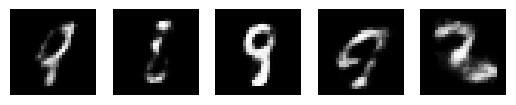

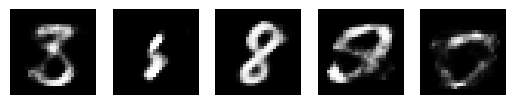

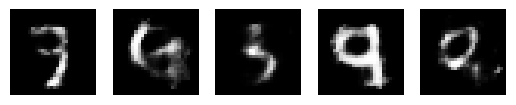

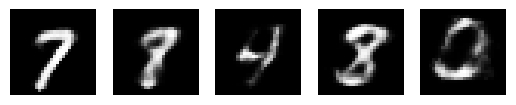

In [118]:
def generate_images_vae(vae_model, n_images=5):
    epsilon = torch.randn(n_images, vae_model.z_dim)
    imgs_generated = vae_model.decoder(epsilon)
    imgs_generated = imgs_generated.view(n_images, vae_model.n_channels, vae_model.n_rows, vae_model.n_cols)
    return imgs_generated
imgs_generated = generate_images_vae(vae_model,n_images=20)
display_images(imgs_generated[:5])
display_images(imgs_generated[5:10])
display_images(imgs_generated[10:15])
display_images(imgs_generated[15:20])

Do you think the results are better ? What difference can you see ? What advantage does the Variational Autoencoder have over the simple autoencoder model, even though the second autoencoder approach has a more complex probabilistic latent model (a full covariance matrix) ?

**Answer**

|  AE decoder - latent sampled using estimated per component variance | AE decoder - latent sampled using estimated covariance matrix | VAE |
|:--:| :---:|:---:|
|![](figures/ae_latent_diagonal_generation_twenty.png)|![](figures/ae_latent_cov_generation_twenty.png) | ![](figures/vae_generation.png) |

- Sampled VAE results are someties blurry but we do not get totally unstructured garbage like we got using the original Auto-encoder.
- We sometimes get blended digits  (like a blend of a 3 and a 8) - there is no technique used here to enforce partitions of the latent space to match digits categories.
- The VAE has theoretical groundings which led to a very specific kind of training method.

### Statistics of $q_\phi$

Remember, our goal was to create an autoencoder such that the distributions $q_{\phi}(z|x)$ of each input data point in the latent space is a normal distribution, ie such that $\mu=0$ and $\sigma=1$ for all inputs. Let us see if this goal was attained.

For this, take a batch of test images, and calculate the vectors $\mu=0$ and $\sigma=1$ of these images (recall that they should be 0 and 1). Now,use a 2D scatter plot on any two of the latent coordinates to visualise the values of $\mu$ and $\sigma$ (you can try several different combinations of the latent coordinates.

You will need to use ```detach().numpy()``` to plot these values.

In [ ]:
# FILL IN STUDENT

Do we indeed see most values around $\mu=0$, $\sigma=1$ ? Is this in fact possible ? Why ? What compromise are we trying to achieve ?

__Your answer:__

Let us now compare the three models (AE diagonal covariance, AE full covariance and VAE) quantitavely.

# 3 Evaluating and comparing the models

We will evaluate the models, in the following manner:

- we train a simple convolutional neural network classifier on mnist, to a good accuracy
- we generate images with each model
- we find the average of the highest probability of the images according to the classifier, for each model. If this value is high, it means that on average the classifier considers that the images look like a 

We will use the following convoluional architecture for the classifier:

- conv2d, filter size  3×3 , 32 filters, stride=(2,2), padding="SAME"
- ReLU
- conv2d, filter size  3×3 , 32 filters, stride=(2,2), padding="SAME"
- ReLU
- MaxPool2D, stride=(2,2)
- Flatten
- Dense layer

Now, define the model. To make things easier, use the ```torch.nn.Sequential``` API (there is no need for a Class in this simple case).

In [222]:
class DigitClassifier(torch.nn.Module):
    def __init__(
        self,
        n_h_0: int = 1,  # greyscale input images
        n_h_1: int = 32,
        n_h_2: int = 32,
        kernel_size: Tuple[int, int] = (3, 3),
        pool_size: Tuple[int, int] = (2, 2),
        image_sizes: Tuple[int, int] = (28, 28),
        n_digits: int = 10
    ):
        super().__init__()
        self.non_linearity = torch.nn.ReLU()
        # Using padding=`valid` instead of same as there's an asserted ambiguity in torch.
        # Let's be pragmatic here, borders are black in these digit images basically so padding with zeros won't be a big deal
        self.conv1 = torch.nn.Conv2d(n_h_0, n_h_1, kernel_size=kernel_size, stride=2, padding=kernel_size[0]//2)
        self.conv2 = torch.nn.Conv2d(n_h_1, n_h_2, kernel_size=kernel_size, stride=2, padding=kernel_size[0]//2)
        self.maxpool = torch.nn.MaxPool2d(kernel_size=pool_size, stride=2)
        self.stack_of_conv = torch.nn.Sequential(
            self.conv1, self.non_linearity, self.conv2, self.non_linearity, self.maxpool
        )
        # Forward pass to compute the size of the flattened output.
        # https://pytorch.org/docs/stable/generated/torch.nn.LazyLinear.html
        out = self.stack_of_conv(torch.rand(1, n_h_0, image_sizes[0], image_sizes[1]))
        print(f"Thumbnail size which goes into the dense classification head {out[0, ...].shape}")
        flattened_size = out.view(-1).shape[0]
        self.fc1 = torch.nn.Linear(flattened_size, n_digits)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        batch_size = x.shape[0]
        x = self.stack_of_conv(x)
        x = x.view(batch_size, -1)
        logits = self.fc1(x)
        return logits


digit_classifier = DigitClassifier()
img_in = torch.rand(64, 1, 28, 28)
digit_classifier(img_in).shape
digit_classifier.conv2(digit_classifier.conv1(img_in)).shape

Thumbnail size which goes into the dense classification head torch.Size([32, 3, 3])


torch.Size([64, 32, 7, 7])

In [240]:
learning_rate = 0.01
n_epochs = 20
batch_size = 64
nb_classes = int(mnist_trainset.targets.max()+1)

# number of convolutional filters to use
nb_filters = 32
# convolution kernel size
kernel_size = (3, 3)
# size of pooling area for max pooling
pool_size = (2, 2)

# --- Size of the successive layers
n_h_0 = 1 #greyscale input images
n_h_1 = nb_filters
n_h_2 = nb_filters

mnist_classification_model = DigitClassifier(n_h_0, n_h_1, n_h_2, kernel_size, pool_size, n_digits=nb_classes) # FILL IN CODE HERE

criterion = torch.nn.CrossEntropyLoss() # FILL IN CODE HERE
optimizer = torch.optim.Adam(mnist_classification_model.parameters(), lr=learning_rate) #, weight_decay=0.02)

Thumbnail size which goes into the dense classification head torch.Size([32, 3, 3])


Create a function to calculate accuracy, instead of loss

In [241]:
def get_accuracy(x_pred,x_label):
  acc = torch.sum(x_pred == x_label)/(x_pred.shape[0])
  return acc

Now, train the model. You should be able to achieve an accuracy close to 1.00 within 20 epochs

Epoch:0 Train Loss:0.0176 Accuracy: Train 14.2857% | Val 20.5078%
Epoch:1 Train Loss:0.0122 Accuracy: Train 35.3795% | Val 52.7344%
Epoch:2 Train Loss:0.0065 Accuracy: Train 64.9554% | Val 75.9766%
Epoch:3 Train Loss:0.0036 Accuracy: Train 81.1384% | Val 87.3047%
Epoch:4 Train Loss:0.0023 Accuracy: Train 87.9464% | Val 89.2578%
Epoch:5 Train Loss:0.0021 Accuracy: Train 90.5134% | Val 90.0391%
Epoch:6 Train Loss:0.0025 Accuracy: Train 93.4152% | Val 91.7969%
Epoch:7 Train Loss:0.0018 Accuracy: Train 94.1964% | Val 91.0156%
Epoch:8 Train Loss:0.0013 Accuracy: Train 95.9821% | Val 91.7969%
Epoch:9 Train Loss:0.0011 Accuracy: Train 95.9821% | Val 92.5781%
Epoch:10 Train Loss:0.0005 Accuracy: Train 97.0982% | Val 92.1875%
Epoch:11 Train Loss:0.0007 Accuracy: Train 97.3214% | Val 92.5781%
Epoch:12 Train Loss:0.0006 Accuracy: Train 97.9911% | Val 92.1875%
Epoch:13 Train Loss:0.0007 Accuracy: Train 98.6607% | Val 93.7500%
Epoch:14 Train Loss:0.0001 Accuracy: Train 98.3259% | Val 92.9688%
Epoch

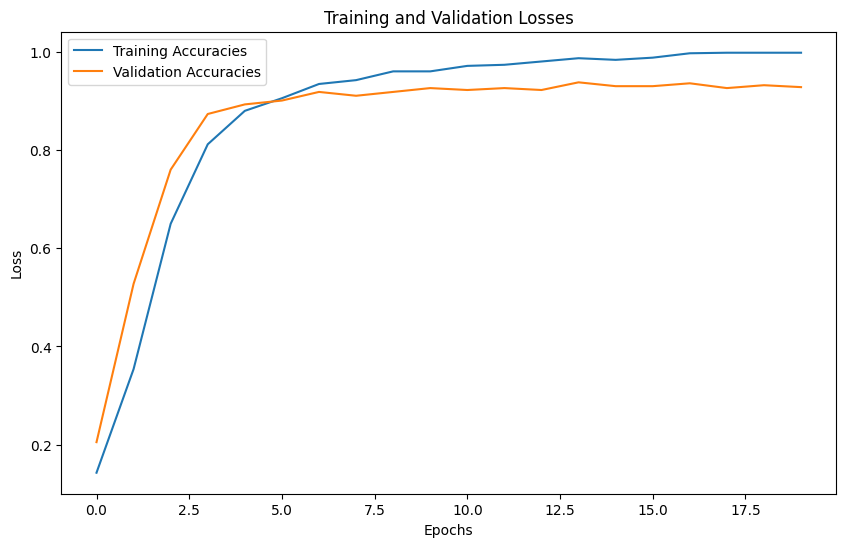

In [242]:
train_losses = []
valid_losses = []
train_accuracies = []
valid_accuracies = []

for epoch in range(0, n_epochs):
    train_loss = 0.0
    train_acc = 0.
    mnist_classification_model.train()
    for batch_idx, (imgs, labels) in enumerate(mnist_train_loader):
        # set the gradients back to 0
        optimizer.zero_grad()
        predict = mnist_classification_model(imgs)
        # apply loss function
        loss = criterion(predict, labels)
        train_acc += get_accuracy(torch.argmax(predict, dim=1), labels)
        # backpropagation
        loss.backward()
        optimizer.step()
        train_loss = loss.item()
    train_acc /= len(mnist_train_loader)
    train_accuracies.append(train_acc)
    
    val_acc = 0.
    with torch.no_grad():
        for batch_idx, (imgs, labels) in enumerate(mnist_test_loader):
            predict = mnist_classification_model(imgs)
            val_acc += get_accuracy(torch.argmax(predict, dim=1), labels)
    val_acc /= len(mnist_test_loader)
    valid_accuracies.append(val_acc)
    print('Epoch:{} Train Loss:{:.4f} Accuracy: Train {:.4%} | Val {:.4%}'.format(epoch, train_loss/imgs.shape[0], train_acc, val_acc))

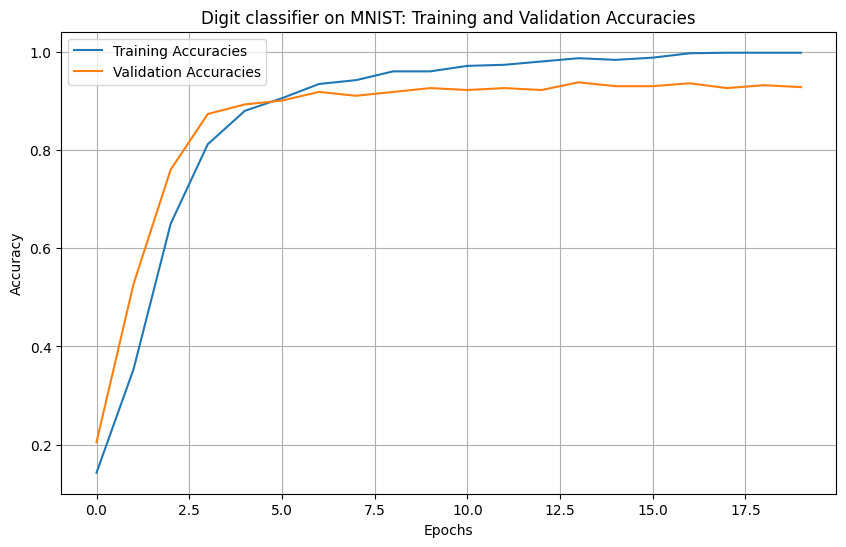

In [244]:
plt.figure(figsize=(10, 6))
plt.plot(train_accuracies, label='Training Accuracies')
plt.plot(valid_accuracies, label='Validation Accuracies')
plt.grid()
plt.title('Digit classifier on MNIST: Training and Validation Accuracies')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

### Evaluate the average maximum prediction of the images generated by each generative model (higher is better)

Now, we will evaluate the models. For each ones, produce a certain number of images, and put those images through the classification network. Then find the maximum class probability of each image, and average it over all the images. We will use this as a metric to evaluate each model.

__CAREFUL__: the output of the network does __not__ include the Softmax layer, so you will have to carry it out, with:
- ```torch.nn.Softmax()(...)```

Define this metric now:

In [245]:
def generative_model_score(imgs_in, classification_model):
  classification_model.eval()
  with torch.no_grad():
    logits = classification_model(imgs_in)
    probabilities = torch.nn.functional.softmax(logits, dim=-1)
    gen_score = torch.mean(torch.max(probabilities, dim=-1).values)
    return(gen_score)

Now, generate some images with each of the three models, and evaluate these models:

In [248]:
n_images = 50000
imgs_diagonal_gaussian = generate_images_diagonal_gaussian(ae_model, z_average, z_sigma, n_images=n_images)
imgs_non_diagonal_gaussian = generate_images_non_diagonal_gaussian(ae_model, z_average, z_covariance, n_images=n_images)
imgs_vae = generate_images_vae(vae_model, n_images=n_images)

# average of maximum of first model
diagonal_gaussian_score = float(generative_model_score(imgs_diagonal_gaussian, mnist_classification_model))
non_diagonal_gaussian_score = float(generative_model_score(imgs_non_diagonal_gaussian, mnist_classification_model))
vae_gaussian_score = float(generative_model_score(imgs_vae, mnist_classification_model))

print(f"Diagonal gaussian generative model score : {diagonal_gaussian_score:.4%}")
print(f"Non diagonal gaussian generative model score : {non_diagonal_gaussian_score:.4%}")
print(f"Variational autoencoder model score: {vae_gaussian_score:.4%}")

Diagonal gaussian generative model score : 75.8274%
Non diagonal gaussian generative model score : 80.8801%
Variational autoencoder model score: 85.0771%


Please answer the following questions:

- Which model is better quantitatively ? 
- Do the quantitative result support the qualitative results ?
- Can you see any drawbacks of this method of evaluation ?
- Can you propose any more sophisticated models than the multivariate Gaussian approach (apart from the variational autoencoder) ? 

__Your answer__